In [1]:
import seaborn as sns
import pandas as pd

df_16 = pd.read_csv("../results/16jobs_results.csv")
df_4 = pd.read_csv("../results/4jobs_results.csv")


In [2]:
df_16

,experiment,repetition,runtime,max_mem
0,lustre,0,74.89,1942844
1,lustre,0,75.42,1942156
2,mem_all,0,143.03,1961564
3,mem_final,0,184.31,1960364
4,lustre,1,54.58,1939564
5,mem_final,1,184.28,1958296
6,lustre,1,54.51,1942788
7,mem_all,1,143.67,1959804
8,lustre,2,70.98,1942112
9,mem_final,2,186.34,1958784


# Experiment 1 - 16 parallel jobs & 39 617MB images incremented 10 times (total data generated: ~234GiB)

(0.0, 193.0525)

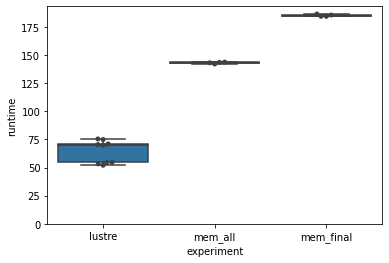

In [3]:
ax = sns.boxplot(x="experiment", y="runtime", data=df_16)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_16, color=".25")
ax.set_ylim(bottom=0)

## Experiment 2 - 4 parallel jobs & 39 617MB images incremented 10 times (total data generated:~234GiB)

(0.0, 202.513)

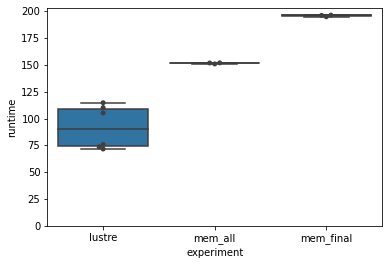

In [4]:
ax = sns.boxplot(x="experiment", y="runtime", data=df_4)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_4, color=".25")
ax.set_ylim(bottom=0)

## Experiment 3 - 16 parallel jobs & Single node multidisk (all 6) & 39 617MB images incremented 10 times

In [5]:
multidisk = pd.read_csv("../results/multidisk_res.csv")
print(multidisk)
multidisk['flush_time_s'] = multidisk['flush_time'].apply(lambda x: float(x.strip('s').split('m')[1]) if pd.notnull(x) else 0)
multidisk['flush_time'] = multidisk['flush_time'].apply(lambda x: float(x.strip('s').split('m')[0])*60 if pd.notnull(x) else 0)
multidisk['flush_time_s'] = multidisk['flush_time'] + multidisk['flush_time_s']
multidisk['runtime'] = multidisk['runtime'].apply(lambda x: float(x))
multidisk = multidisk[['experiment', 'repetition', 'runtime', 'disk_files', 'total_flush', 'flush_time_s']]

  experiment  repetition  runtime  max_mem flush_time  disk_files  total_flush
0    mem_all           0   124.08        0   0m5.728s           0          390
1  mem_final           0    82.92        0   0m0.133s          22           39
2     lustre           0   114.17        0        NaN           0            0
3     lustre           1   115.69        0        NaN           0            0
4    mem_all           1   123.32        0   0m1.446s           0          390
5  mem_final           1    82.57        0   0m0.114s          22           39
6    mem_all           2   116.67        0   0m0.709s           0          390
7     lustre           2   117.65        0        NaN           0            0
8  mem_final           2    80.42        0   0m0.130s          22           39


In [6]:
multidisk

,experiment,repetition,runtime,disk_files,total_flush,flush_time_s
0,mem_all,0,124.08,0,390,5.728
1,mem_final,0,82.92,22,39,0.133
2,lustre,0,114.17,0,0,0.000
3,lustre,1,115.69,0,0,0.000
4,mem_all,1,123.32,0,390,1.446
5,mem_final,1,82.57,22,39,0.114
6,mem_all,2,116.67,0,390,0.709
7,lustre,2,117.65,0,0,0.000
8,mem_final,2,80.42,22,39,0.130


(0.0, 126.263)

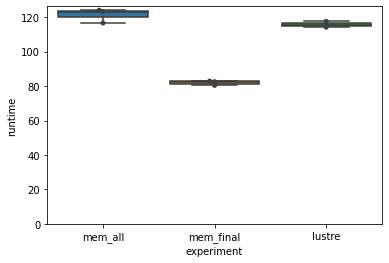

In [7]:
ax = sns.boxplot(x="experiment", y="runtime", data=multidisk)
ax = sns.swarmplot(x="experiment", y="runtime", data=multidisk, color=".25")
ax.set_ylim(bottom=0)

(0.0, 132.27089999999998)

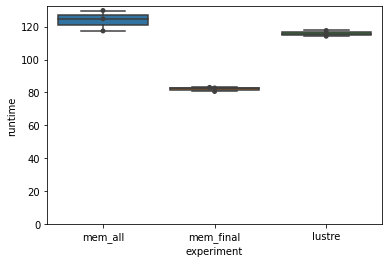

In [8]:
multidisk['runtime'] = multidisk['runtime'] + multidisk['flush_time_s']
ax = sns.boxplot(x="experiment", y="runtime", data=multidisk)
ax = sns.swarmplot(x="experiment", y="runtime", data=multidisk, color=".25")
ax.set_ylim(bottom=0)

## Experiment 3 Gantt Charts

In [26]:
colours = ["#c9d9d3", "#718dbf", "#e84d60"]

def bokeh_gantt(df):
    from bokeh.io import output_notebook, show
    from bokeh.models import ColumnDataSource, HoverTool, Legend, LegendItem
    from bokeh.plotting import figure
    
    output_notebook()
    source = ColumnDataSource(df)
    
    p = figure(toolbar_location="below", x_range=(0,130), y_range=sorted(df['pid'].unique()))
    r = p.hbar(y="pid", left="start", right="end", height=0.4,
               fill_color="color", source=source)

    p.ygrid.grid_line_color = None
    p.xaxis.axis_label = "Time (seconds)"
    p.yaxis.axis_label = "PID"
    
    legend = Legend(items=[
        LegendItem(label="read", renderers=[r], index=0),
        LegendItem(label="increment", renderers=[r], index=1),
        LegendItem(label="write", renderers=[r], index=2),
        
    ])
    p.add_layout(legend)

    p.outline_line_color = None
    p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
        ('Task', '@action'),
        ('Image', '@img'),
        ('Start', '@start'),
        ('End', '@end'),
        ('Duration', "@duration")
    ]))
    
    show(p)
    
def bokeh_stacked(df):
    from bokeh.io import output_notebook, show
    from bokeh.models import ColumnDataSource, HoverTool, Legend, LegendItem
    from bokeh.plotting import figure
    
    output_notebook()
    
    actions = ["read", "increment", "write"]
    source = ColumnDataSource(df)

    p = figure(x_range=df["type"], toolbar_location="below",
               tools="hover", tooltips=[("Task","$name"), ("Duration", "@$name")])

    p.vbar_stack(actions, x="type", width=0.9, fill_color=colours, source=source,
                 legend_label=actions)

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.orientation = "horizontal"

    show(p)
    
    
def group_actions(in_mem_df, mem_flush_df, lustre_df):
    
    group = lambda df: df[["action", "duration"]].groupby(["action"]).sum().reset_index()
    
    in_mem_df = group(in_mem_df)
    in_mem_df["type"] = "Sea - In memory"
    
    mem_flush_df = group(mem_flush_df)
    mem_flush_df["type"] = "Sea - Flush all"
    
    lustre_df = group(lustre_df)
    lustre_df["type"] = "Lustre"
    
    df = pd.concat([in_mem_df, mem_flush_df, lustre_df], axis=0)
    
    
    df_read = (df[df['action'].str.contains('read')]
               .rename(columns={ "duration" : "read" }))

    df_increment = (df[df['action'].str.contains('inc')]
                    .rename(columns={ "duration" : "increment"}))
    df_write = (df[df['action'].str.contains('save')]
                .rename(columns={ "duration" : "write" }))
        
    df = pd.merge(df_read, df_increment, on=["type"])
    df = pd.merge(df, df_write, on=["type"])
    
    return df[["type", "read", "increment", "write"]]
    
    
def format_df(df, df_type):
    from datetime import datetime
    df = df[df["action"].str.contains(df_type)]
    #df['time'] = df['time'].apply(lambda x: datetime.fromtimestamp(x))
    df = df.rename(columns={"time": df_type})
    df["action"] = df["action"].apply(lambda x: x.split('_')[0])
    df["pid"] = df["pid"].astype("str") # % df["pid"].nunique()
    return df
    
def load_df(fn):
    from datetime import datetime
    df = pd.read_csv(fn, names=["action", "img", "time", "pid"], header=None)
    df_start = format_df(df, "start")
    df_end = format_df(df, "end")
    
    #df_end["end"] += 1
    
    #df_start["start"] = df_start["start"].apply(lambda x: datetime.fromtimestamp(x))
    #df_end["end"] = df_end["end"].apply(lambda x: datetime.fromtimestamp(x))
    
    df = pd.merge(df_start, df_end, on=["action","img", "pid"])
    df.loc[df["action"] == "read", "color"] = colours[0]
    df.loc[df["action"] == "inc", "color"] = colours[1]
    df.loc[df["action"] == "save", "color"] = colours[2]
    
    start_time = df["start"].min()
    df["start"] = df["start"] - start_time
    df["end"] = df["end"] - start_time
    df["duration"] = df["end"] - df["start"]
        
    return df


## Gantt Chart - Sea flush all files

In [27]:
fa_df = load_df("../results/mem_all-1/benchmarks.out")
bokeh_gantt(fa_df)

Loading BokehJS ...

## Gantt chart - Sea flush only final output (in-mem computing)

In [28]:
im_df = load_df("../results/mem_final-1/benchmarks.out")
bokeh_gantt(im_df)

Loading BokehJS ...

## Gantt chart - Write everything to Lustre

In [29]:
l_df = load_df("../results/lustre-1/benchmarks.out")
bokeh_gantt(l_df)

Loading BokehJS ...

In [30]:
df = group_actions(fa_df, im_df, l_df)
df.head()

,type,read,increment,write
0,Sea - In memory,1418.523927,85.514787,149.634782
1,Sea - Flush all,759.957204,81.389379,195.784697
2,Lustre,1140.922234,80.738076,296.826842


In [32]:
bokeh_stacked(df)

Loading BokehJS ...